# Training and Fine-Tuning of MobileNetV3

In this notebook MobileNetV3 small is fine-tuned on the ASL MNIST dataset to allow for real time sign language detection

## 1: Setup and Library Installation

In [1]:
#pip install kaggle
#pip install kagglehub
#pip install tensorflow

In [3]:
# Install necessary libraries
#!pip install kagglehub
#!pip install tensorflow

import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

## 2: Dataset Preparation

First the dataset is downloaded from the Kaggle repository "Sign Language MNIST"

In [3]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

# Load training and testing data
train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

100%|██████████| 62.6M/62.6M [00:01<00:00, 53.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


The dataset is processed into a dataframe and inputs that MobileNetV3 is designed to take (96 x 96 rgb). Note that this involves significant upscaling of the data from 24 x 24 grayscale, or almost a 50X upscaling. In the future larger images with rgb could be investigated for improvement.

***Print model summary for an easy read**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Separate features (pixels) and labels (class)
X_train = train_data.drop(columns='label').values
y_train = train_data['label'].values
X_test = test_data.drop(columns='label').values
y_test = test_data['label'].values

# Reshape data into 32x32x3 images (RGB)
X_train = X_train.reshape(-1, 28, 28, 1)  # Assuming original images are 28x28 grayscale
X_test = X_test.reshape(-1, 28, 28, 1)
X_train = tf.image.resize(X_train, [32, 32])  # Resize to 32x32
X_test = tf.image.resize(X_test, [32, 32])
X_train = tf.image.grayscale_to_rgb(X_train)  # Convert to RGB
X_test = tf.image.grayscale_to_rgb(X_test)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert X_train and X_test to NumPy arrays
X_train = X_train.numpy()
X_test = X_test.numpy()

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=25)  # 24 classes
y_test = to_categorical(y_test, num_classes=25)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Define data augmentation parameters for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image
    rotation_range=3,  # Rotate by up to 3 degrees
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1,  # Randomly shift vertically
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill in newly created pixels during transformations
)

#NOTE: Adding Data Augmentation here does improve model accuracy! Data Augmentation is not overkill. Inferences can be made. (J.Long)



# Apply data augmentation on training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# If validation data augmentation is not needed (you want to preserve the original validation data):
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build the MobileNetV3Small model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
base_model.trainable = False


# Create the custom top layers
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)


x = Dense(2048, activation='swish')(x)  # Larger dense layer
x = Dropout(0.4)(x)  # More dropout to combat overfitting
x = Dense(1024, activation='swish')(x)  # Add more layers
x = Dropout(0.2)(x)
x = Dense(25, activation='softmax')(x)  # 24 classes for ASL gestures

# Final model
model = Model(inputs, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 1, 1, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,244,617 (16.19 MB)

 Trainable params: 3,305,497 (12.61 MB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.0458 - loss: 3.3096 - val_accuracy: 0.0993 - val_loss: 2.9507
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.0955 - loss: 2.9894 - val_accuracy: 0.0998 - val_loss: 2.9649
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.1194 - loss: 2.8230 - val_accuracy: 0.0874 - val_loss: 2.9568
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.1425 - loss: 2.7183 - val_accuracy: 0.1328 - val_loss: 2.7992
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.1500 - loss: 2.6551 - val_accuracy: 0.1597 - val_loss: 2.5519
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - accuracy: 0.1523 - loss: 2.6159 - val_accuracy: 0.1408 - val_loss: 2.6729
Epoch 7/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.1544 - loss: 2.5971 - val_accuracy: 0.1938 - val_loss: 2.4783
Epoch 8/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.1746 - loss: 2

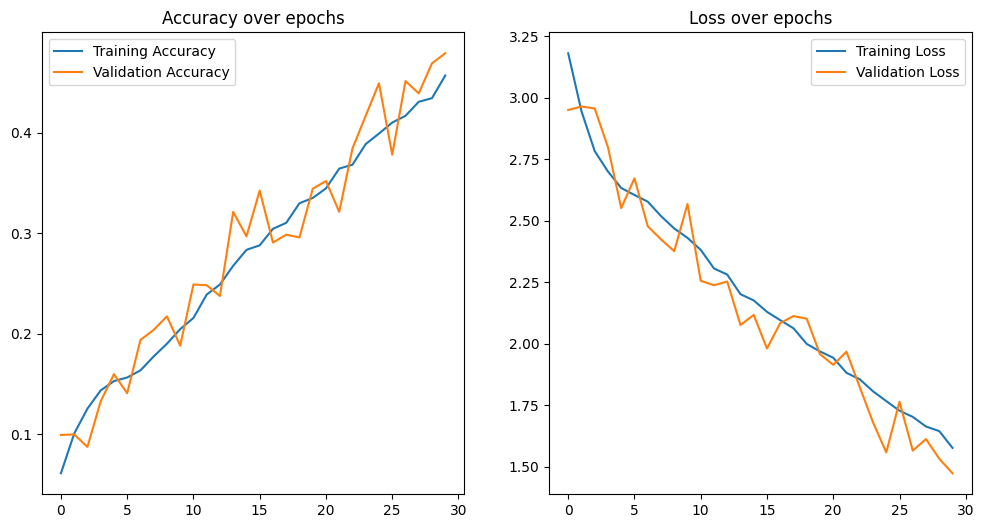

In [5]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

###This model does not generalize quite as well as the one I sent in slack. However, the accuracy increased. We can grasp more and more insight when battling between these relationships of model accuracy and generalization. _(~looking for the sweet spot)_

-Long

In [ ]:
# Define data augmentation parameters for training
train_datagen = ImageDataGenerator(
    rotation_range=6,  # Rotate by up to 3 degrees
    width_shift_range=0.2,  # Randomly shift horizontally
    height_shift_range=0.2,  # Randomly shift vertically
    shear_range=0.2,  # Random shearing
    zoom_range=0.4,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill in newly created pixels during transformations
)

#NOTE: Adding Data Augmentation here does improve model accuracy! Data Augmentation is not overkill. Inferences can be made. (J.Long)



# Apply data augmentation on training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# If validation data augmentation is not needed (you want to preserve the original validation data):
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build the MobileNetV3Small model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
base_model.trainable = False


# Create the custom top layers
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)


x = Dense(2048, activation='swish')(x)  # Larger dense layer
x = Dropout(0.4)(x)  # More dropout to combat overfitting
x = Dense(1024, activation='swish')(x)  # Add more layers
x = Dropout(0.2)(x)
x = Dense(25, activation='softmax')(x)  # 24 classes for ASL gestures

# Final model
model = Model(inputs, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 1, 1, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2048)                │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,244,617 (16.19 MB)

 Trainable params: 3,305,497 (12.61 MB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.0522 - loss: 3.2941 - val_accuracy: 0.0973 - val_loss: 2.9779
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.0948 - loss: 2.9757 - val_accuracy: 0.1051 - val_loss: 2.8713
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1182 - loss: 2.8321 - val_accuracy: 0.1384 - val_loss: 2.7926
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1317 - loss: 2.7291 - val_accuracy: 0.1359 - val_loss: 2.7192
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1458 - loss: 2.6383 - val_accuracy: 0.1588 - val_loss: 2.5586
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1545 - loss: 2.6058 - val_accuracy: 0.1787 - val_loss: 2.5067
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1658 - loss: 2.5626 - val_accuracy: 0.1537 - val_loss: 2.6573
Epoch 8/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1658 - loss: 2.5456 - val_accuracy: 

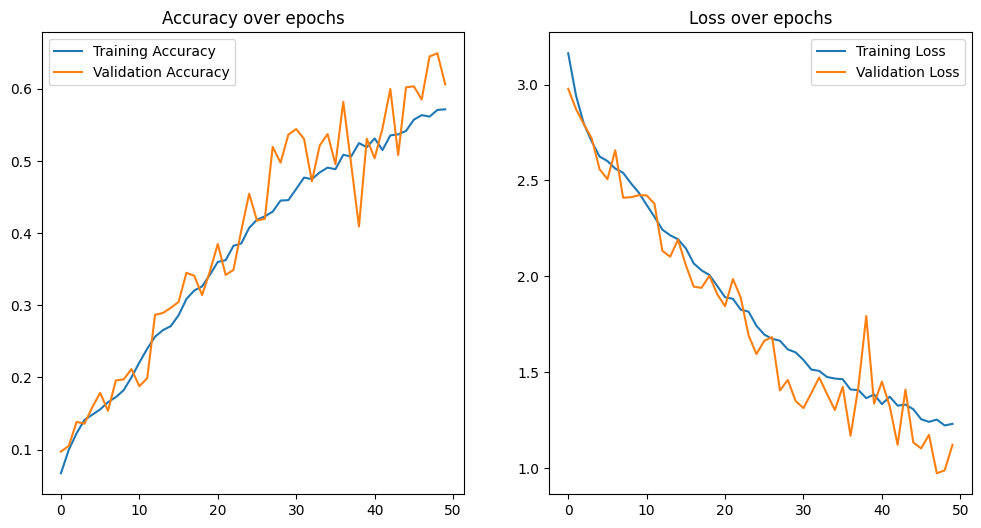

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

Evaluation Metrics

In [9]:
# Constants
NUM_CLASSES = len(np.unique(np.argmax(y_test, axis=1)))  # Dynamically determine number of classes

In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 39.07%


In [11]:
# Get predictions and true labels
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true = np.argmax(y_test, axis=1)  # True classes

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step


In [12]:
# F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.39


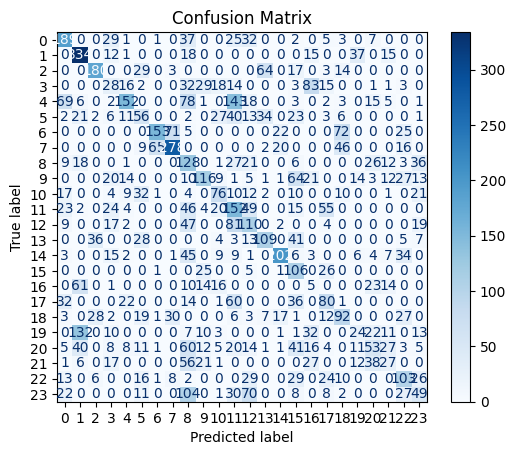

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=range(NUM_CLASSES)).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


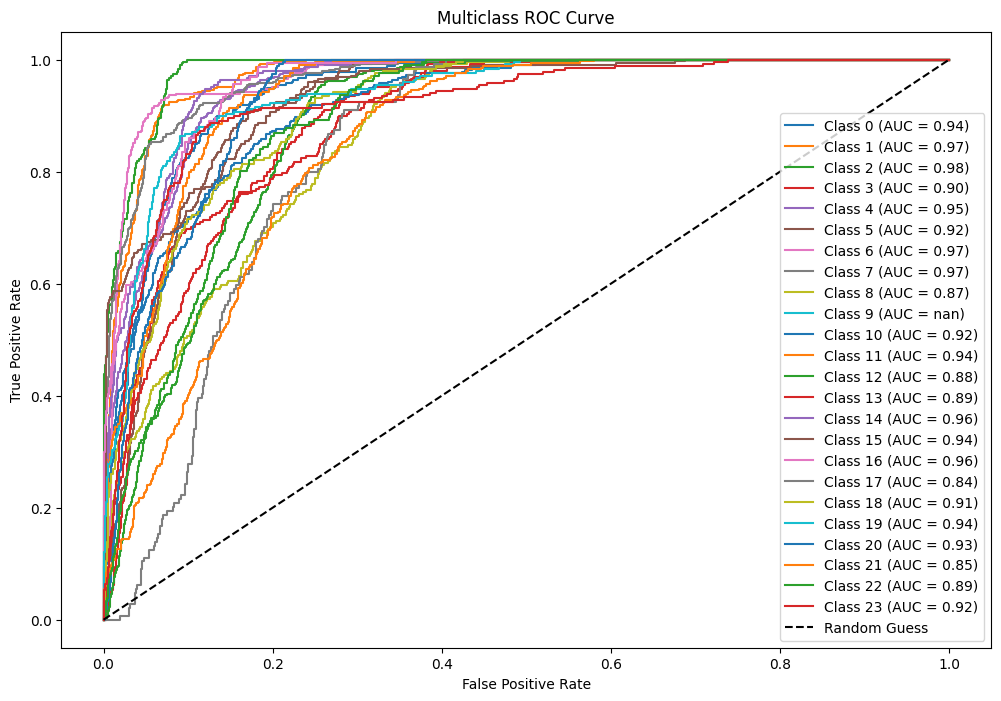

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [15]:
# AUC-ROC Curve
if len(np.unique(y_true)) > 1:
    if NUM_CLASSES > 2:
        # Binarize the true labels for multiclass ROC
        y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))

        plt.figure(figsize=(12, 8))
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multiclass ROC Curve')
        plt.legend(loc='best')
        plt.show()
    else:
        # Binary classification case
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='best')
        plt.show()

    print(f"AUC-ROC: {roc_auc_score(label_binarize(y_true, classes=range(NUM_CLASSES)), y_pred_probs, multi_class='ovr'):.2f}")
else:
    print("AUC-ROC cannot be calculated: Only one class is present in y_true.")



## Analysis of Evaluation Metrics


Test Accuracy (39.07%):

The model is correctly predicting the class for only about 39% of the test samples, which is relatively low.


F1-Score (0.39):

An F1-Score of 0.39, which is consistent with the accuracy, suggests that the precision and recall are also low and the model struggles with balanced performance across classes.


Multiclass Curve analysis:

The dashed diagonal line represents a random classifier, where the true positive rate equals the false positive rate. Any ROC curve significantly above this line indicates better-than-random performance.

The model performs exceptionally well for most classes, with several AUC scores exceeding 0.95, indicating high discriminative ability.

However, Class 9 has an AUC value of NaN, which indicates that this class might not be present in the y_true (true labels), causing issues during calculation.

### Steps to improving accuracy are working, Maybe implement technique that helps the model generalize & prevent overfitting

In [18]:
# Define data augmentation parameters for training
train_datagen = ImageDataGenerator(
    rotation_range=6,  # Rotate by up to 3 degrees
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1,  # Randomly shift vertically
    shear_range=0.1,  # Random shearing
    zoom_range=0.3,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill in newly created pixels during transformations
)

#NOTE: Adding Data Augmentation here does improve model accuracy! Data Augmentation is not overkill. Inferences can be made. (J.Long)



# Apply data augmentation on training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# If validation data augmentation is not needed (you want to preserve the original validation data):
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build the MobileNetV3Small model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
base_model.trainable = False


# Create the custom top layers
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)


x = Dense(2048, activation='swish')(x)  # Larger dense layer
x = Dropout(0.5)(x)  # More dropout to combat overfitting
x = Dense(1024, activation='swish')(x)  # Add more layers
x = Dropout(0.25)(x)
x = Dense(25, activation='softmax')(x)  # 24 classes for ASL gestures

# Final model
model = Model(inputs, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 1, 1, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,244,617 (16.19 MB)

 Trainable params: 3,305,497 (12.61 MB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 61s 80ms/step - accuracy: 0.0451 - loss: 3.3045 - val_accuracy: 0.0836 - val_loss: 3.0434
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - accuracy: 0.0829 - loss: 3.0517 - val_accuracy: 0.0998 - val_loss: 2.9220
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.0914 - loss: 2.9608 - val_accuracy: 0.0996 - val_loss: 2.8904
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.1118 - loss: 2.8782 - val_accuracy: 0.1237 - val_loss: 2.7385
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.1301 - loss: 2.7522 - val_accuracy: 0.1563 - val_loss: 2.6669
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.1403 - loss: 2.7119 - val_accuracy: 0.1510 - val_loss: 2.7165
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.1445 - loss: 2.6608 - val_accuracy: 0.1579 - val_loss: 2.6179
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.1534 - loss: 2.6169 - 

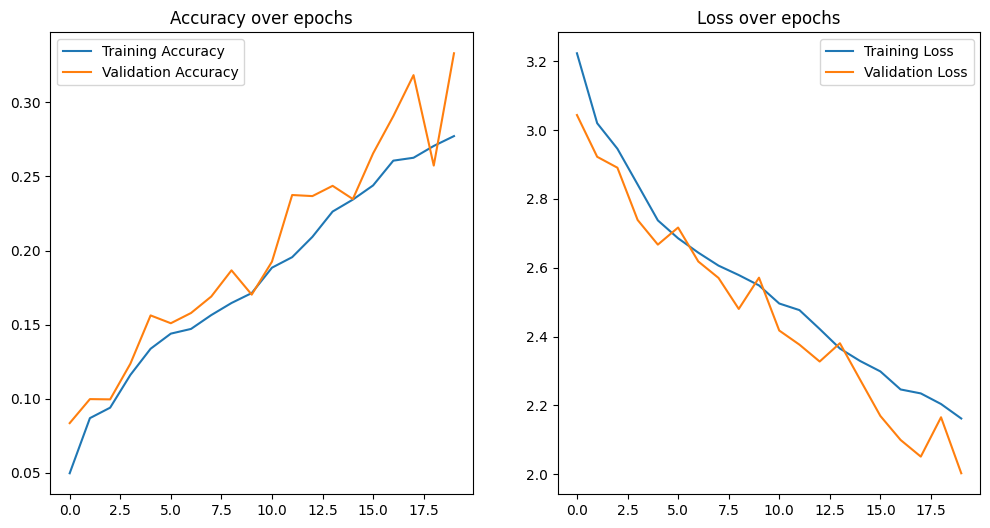

In [17]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

In [19]:
# Define constants for data handling
BATCH_SIZE = 16
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 25

# Create tf.data.Dataset for Training and Test Data
def preprocess_image(image, label):
    # Reshape to 28x28 and add channel dimension
    image = tf.reshape(image, [28, 28, 1])
    # Resize to 96x96
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    # Extract features and labels
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [20]:
# Prepare training, validation, and test datasets
train_val_split = int(len(train_data) * 0.8)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)

## 3: Grid Search for Hyperparameters

Model fine-tuning was performed over several different key hyperparameters including dropout, learning rate and hidden layer size.

In [ ]:
def create_model(img_height, img_width, num_classes, dense_size=256, dropout_rate=0.5):

    # Load the base MobileNetV3 model with ImageNet weights
    base_model = MobileNetV3Small(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

    # Define the model architecture
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)  # Add dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# First create the model, this assigns the output of the function create_model to the variable model
model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Now you can display the summary, as the variable model is assigned in the global scope
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 3, 3, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,093,257 (4.17 MB)

 Trainable params: 1,081,145 (4.12 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
import tensorflow as tf

# Check if a GPU is available
print("Is GPU available:", tf.config.list_physical_devices('GPU'))



Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
tf.debugging.set_log_device_placement(True)

# Run a simple matrix multiplication again to check the device usage
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    c = tf.matmul(a, b)

# The log will show whether the operations are placed on the GPU or CPU


In [ ]:
!nvidia-smi


Sat Dec  7 16:33:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8              14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
with tf.device('/GPU:0'):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)


Epoch 1/20


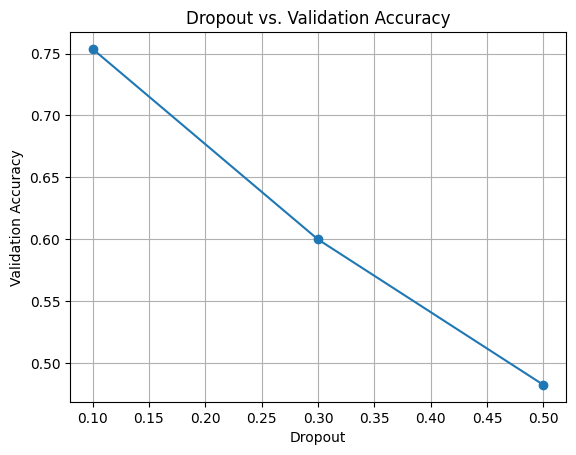

In [ ]:
# Plot dropout vs. validation score

plt.plot(dropouts, dropout_val_scores, marker='o')
plt.xlabel('Dropout')
plt.ylabel('Validation Accuracy')
plt.title('Dropout vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
DROPOUT = dropouts[np.argmax(dropout_val_scores)]
print(f"Best Dropout: {DROPOUT}")

Best Dropout: 0.1


Overall the model performance decreased with increased dropout. This is likely due to the fact that a strong dropout is prohibiting the model from developing strong patterns with specific hidden units to recognize shapes for ASL detection. As the data augmentation is already aggressive, it may be that including strong dropout combines with augmentation to prevent the model from learning at a reasonable rate.

#### Set 2: Learning Rate 1e-4 to 1e-6

In [ ]:
lr_val_scores = []
learning_rates = [1e-4, 1e-5, 1e-6]

In [ ]:
for lr in learning_rates:
    model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

    # Get the last validation score
    last_val_score = history.history['val_accuracy'][-1]
    lr_val_scores.append(last_val_score)

    print(f"Learning rate: {lr}, Validation Accuracy: {last_val_score}")

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Learning rate: 0.0001, Validation Accuracy: 0.96030592918396
Learning rate: 1e-05, Validation Accuracy: 0.7195921540260315
Learning rate: 1e-06, Validation Accuracy: 0.05863073468208313


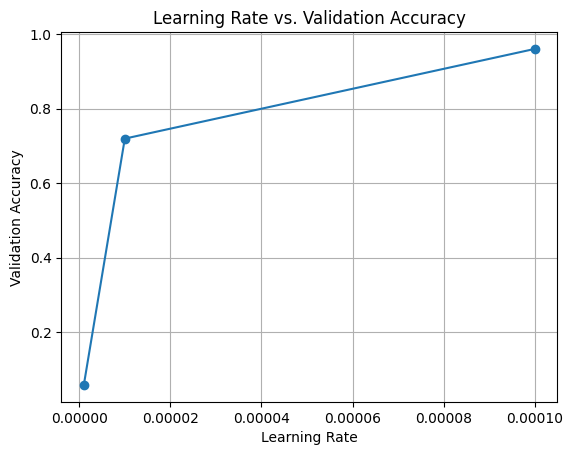

In [ ]:
# Plot learning rate vs. validation score

plt.plot(learning_rates, lr_val_scores, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
LR = learning_rates[np.argmax(lr_val_scores)]
print(f"Best Learning Rate: {LR}")

Best Learning Rate: 0.0001


Different learning rates show that the model learns much better with higher, more aggressive learning rates. This indicates that the model needs to make significant changes to the final layer for ASL detection and that higher learning rates enable it to optimize the weights quicker. In the future it would be useful to try learning rate decay, where a high learning rate is used to start with and the learning rate gradually decreases with each training epoch.

#### Set 3: Dense Size 128 to 512

In [ ]:
# Reset best values after notebook crash

LR = 0.0001
DROPOUT = 0.1

In [ ]:
dense_size_val_scores = []
dense_sizes = [128, 256, 512]

In [ ]:
for d in dense_sizes:
    model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=d, dropout_rate=DROPOUT)
    model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

    # Get the last validation score
    last_val_score = history.history['val_accuracy'][-1]
    dense_size_val_scores.append(last_val_score)

    print(f"Dense Size: {d}, Validation Accuracy: {last_val_score}")

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dense Size: 128, Validation Accuracy: 0.9420976042747498
Dense Size: 256, Validation Accuracy: 0.4850691854953766
Dense Size: 512, Validation Accuracy: 0.930808424949646


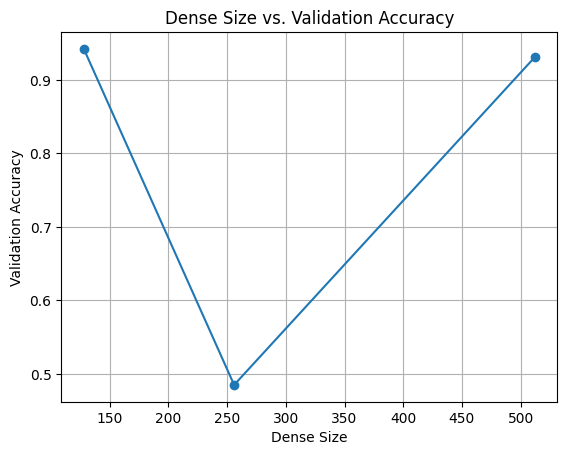

In [ ]:
# Plot dense size vs. validation score

plt.plot(dense_sizes, dense_size_val_scores, marker='o')
plt.xlabel('Dense Size')
plt.ylabel('Validation Accuracy')
plt.title('Dense Size vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
DENSE_SIZE = dense_sizes[np.argmax(dense_size_val_scores)]
print(f"Best Dense Size: {DENSE_SIZE}")

Best Dense Size: 128


The dense size showed an unusual pattern with hidden layer size and final validation accuracy. For hidden size of 128 and 512 the results are roughly similar, however there is a significant drop at 256. Looking at the training curves in upcoming sections this is likely just due to instability in the validation accuracy, where the model at 256 dense size happened to end with low validation accuracy.